In [25]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset
import matplotlib.pyplot as plt

In [26]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [27]:
dataset = ProteinDataset("data/single", numeric_columns=['protein_probability'], label_column='protein_probability_soft_label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)

Rebuilding...
Done!


In [28]:
import copy
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = dataset[0].to(device, 'x', 'y', 'train_mask', 'val_mask', 'test_mask')

In [29]:
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score

# 
approx_train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

train_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

val_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

test_collection = torchmetrics.MetricCollection(
    BinaryAccuracy(),
    BinaryAUROC(),
    BinaryF1Score()
)

approx_train_tracker = torchmetrics.wrappers.MetricTracker(approx_train_collection)
train_tracker = torchmetrics.wrappers.MetricTracker(train_collection)
val_tracker = torchmetrics.wrappers.MetricTracker(val_collection)
test_tracker = torchmetrics.wrappers.MetricTracker(test_collection)
    

In [30]:
kwargs = {'batch_size': 128, 'num_workers': 4, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[20], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        # a single conv layer and a single linear layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.lin1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = x.relu_()
            x = self.lin1(x)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                x = x.relu_()
                x = self.lin1(x)
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all


model = SAGE(dataset.num_features, 10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')
    
    total_loss = total_examples = 0
    approx_train_tracker.increment() # the start of a new epoch
    
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        logits = model(batch.x, batch.edge_index.to(device))[:batch.batch_size].squeeze(-1)
        
        # create hard label only for confidence proteins and used for binary classification evaluation
        y_pred_prob = torch.nn.functional.sigmoid(logits)
        y_hard = torch.where(y > 0.99, 1, 
                             torch.where(y < 0.5, 0, -1))
        binary_mask = (y_hard != -1).bool()
        y_hard = y_hard.to(y_pred_prob.device)
        y = y.to(y_pred_prob.device)
        
        loss = F.binary_cross_entropy_with_logits(logits.squeeze(-1), y)
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * batch.batch_size
        approx_train_tracker.update(y_pred_prob[binary_mask], y_hard[binary_mask])
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples



@torch.no_grad()
def test():
    model.eval()
    logits = model.inference(data.x, subgraph_loader).squeeze(-1)
    y_pred_prob = torch.nn.functional.sigmoid(logits)
 
    # create hard label only for confidence proteins
    y_hard = torch.where(data.y > 0.99, 1, 
                         torch.where(data.y < 0.5, 0, -1))
    binary_mask = (y_hard != -1).bool()
    y_hard = y_hard.to(y_pred_prob.device)
    y = data.y.to(y_pred_prob.device)

    loss = []
    train_tracker.update(y_pred_prob[data.train_mask & binary_mask], y_hard[data.train_mask & binary_mask])
    val_tracker.update(y_pred_prob[data.val_mask & binary_mask], y_hard[data.val_mask & binary_mask])
    test_tracker.update(y_pred_prob[data.test_mask & binary_mask], y_hard[data.test_mask & binary_mask])
    
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        mask = mask & binary_mask
        loss.append(F.binary_cross_entropy_with_logits(logits[mask], y[mask]))
    
    return loss

In [31]:
approx_train_losses = []
train_losses = []
val_losses = []
test_losses = []

times = []
for epoch in range(1, 30):
    start = time.time()
    
    # Evaluation before first training epoch starts
    train_tracker.increment()
    val_tracker.increment()
    test_tracker.increment()

    train_loss, val_loss, test_loss = test()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    train_metrics = train_tracker.compute()
    val_metrics = val_tracker.compute()
    test_metrics = test_tracker.compute()
    
    print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}')
    print(f'Epoch: {epoch:02d}, Train Acc: {train_metrics["BinaryAccuracy"]:.4f}, Val Acc: {val_metrics["BinaryAccuracy"]:.4f}, '
          f'Test AUC: {test_metrics["BinaryAccuracy"]:.4f}')
    print(f'Epoch: {epoch:02d}, Train AUC: {train_metrics["BinaryAUROC"]:.4f}, Val AUC: {val_metrics["BinaryAUROC"]:.4f}, '
          f'Test AUC: {test_metrics["BinaryAUROC"]:.4f}')
    print(f'Epoch: {epoch:02d}, Train F1: {train_metrics["BinaryF1Score"]:.4f}, Val F1: {val_metrics["BinaryF1Score"]:.4f}, '
            f'Test F1: {test_metrics["BinaryF1Score"]:.4f}')
    
    approx_train_loss = train(epoch)
    approx_train_losses.append(approx_train_loss)
    approx_train_metrics = approx_train_tracker.compute()
    print(f'Epoch {epoch:02d}, Approx train loss: {approx_train_loss:.4f}, Approx. Train Acc: {approx_train_metrics["BinaryAccuracy"]:.4f},'
          f'Approx. Train AUC: {approx_train_metrics["BinaryAUROC"]:.4f}, Approx. Train F1: {approx_train_metrics["BinaryF1Score"]:.4f}')
    
    
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Evaluating: 100%|██████████| 10503/10503 [00:02<00:00, 4869.46it/s]


Epoch: 01, Train Loss: 0.7528, Val Loss: 0.7478, Test Loss: 0.7544
Epoch: 01, Train Acc: 0.2511, Val Acc: 0.2813, Test AUC: 0.2466
Epoch: 01, Train AUC: 0.8151, Val AUC: 0.8476, Test AUC: 0.7939
Epoch: 01, Train F1: 0.0000, Val F1: 0.0000, Test F1: 0.0000


Epoch 01: 100%|██████████| 8403/8403 [00:01<00:00, 4286.94it/s]


Epoch 01, Approx train loss: 0.7064, Approx. Train Acc: 0.5693,Approx. Train AUC: 0.7625, Approx. Train F1: 0.6159


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 58913.70it/s]


Epoch: 02, Train Loss: 0.6365, Val Loss: 0.6372, Test Loss: 0.6368
Epoch: 02, Train Acc: 0.8158, Val Acc: 0.8148, Test AUC: 0.8138
Epoch: 02, Train AUC: 0.8727, Val AUC: 0.8928, Test AUC: 0.8594
Epoch: 02, Train F1: 0.8760, Val F1: 0.8714, Test F1: 0.8756


Epoch 02: 100%|██████████| 8403/8403 [00:00<00:00, 118872.47it/s]


Epoch 02, Approx train loss: 0.6185, Approx. Train Acc: 0.7686,Approx. Train AUC: 0.8286, Approx. Train F1: 0.8637


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 56421.35it/s]


Epoch: 03, Train Loss: 0.5537, Val Loss: 0.5599, Test Loss: 0.5528
Epoch: 03, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 03, Train AUC: 0.8734, Val AUC: 0.8924, Test AUC: 0.8621
Epoch: 03, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 03: 100%|██████████| 8403/8403 [00:00<00:00, 112607.31it/s]


Epoch 03, Approx train loss: 0.5494, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8347, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 57640.71it/s]


Epoch: 04, Train Loss: 0.4907, Val Loss: 0.5031, Test Loss: 0.4885
Epoch: 04, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 04, Train AUC: 0.8755, Val AUC: 0.8933, Test AUC: 0.8659
Epoch: 04, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 04: 100%|██████████| 8403/8403 [00:00<00:00, 114217.73it/s]


Epoch 04, Approx train loss: 0.4993, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8368, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 58472.81it/s]


Epoch: 05, Train Loss: 0.4467, Val Loss: 0.4651, Test Loss: 0.4431
Epoch: 05, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 05, Train AUC: 0.8762, Val AUC: 0.8942, Test AUC: 0.8664
Epoch: 05, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 05: 100%|██████████| 8403/8403 [00:00<00:00, 112999.39it/s]


Epoch 05, Approx train loss: 0.4669, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8522, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 56208.19it/s]


Epoch: 06, Train Loss: 0.4208, Val Loss: 0.4438, Test Loss: 0.4163
Epoch: 06, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 06, Train AUC: 0.8767, Val AUC: 0.8952, Test AUC: 0.8659
Epoch: 06, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 06: 100%|██████████| 8403/8403 [00:00<00:00, 114507.18it/s]


Epoch 06, Approx train loss: 0.4540, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8708, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 57729.46it/s]


Epoch: 07, Train Loss: 0.4111, Val Loss: 0.4367, Test Loss: 0.4062
Epoch: 07, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 07, Train AUC: 0.8770, Val AUC: 0.8954, Test AUC: 0.8666
Epoch: 07, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 07: 100%|██████████| 8403/8403 [00:00<00:00, 114236.24it/s]


Epoch 07, Approx train loss: 0.4499, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8722, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 57846.73it/s]


Epoch: 08, Train Loss: 0.4064, Val Loss: 0.4326, Test Loss: 0.4013
Epoch: 08, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 08, Train AUC: 0.8770, Val AUC: 0.8955, Test AUC: 0.8666
Epoch: 08, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 08: 100%|██████████| 8403/8403 [00:00<00:00, 114536.95it/s]


Epoch 08, Approx train loss: 0.4476, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8747, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 58943.33it/s]


Epoch: 09, Train Loss: 0.4026, Val Loss: 0.4288, Test Loss: 0.3977
Epoch: 09, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 09, Train AUC: 0.8769, Val AUC: 0.8955, Test AUC: 0.8666
Epoch: 09, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 09: 100%|██████████| 8403/8403 [00:00<00:00, 116115.01it/s]


Epoch 09, Approx train loss: 0.4459, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8748, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 59200.93it/s]


Epoch: 10, Train Loss: 0.3993, Val Loss: 0.4252, Test Loss: 0.3946
Epoch: 10, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 10, Train AUC: 0.8770, Val AUC: 0.8955, Test AUC: 0.8664
Epoch: 10, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 10: 100%|██████████| 8403/8403 [00:00<00:00, 112130.11it/s]


Epoch 10, Approx train loss: 0.4443, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8742, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 58052.94it/s]


Epoch: 11, Train Loss: 0.3962, Val Loss: 0.4218, Test Loss: 0.3916
Epoch: 11, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 11, Train AUC: 0.8769, Val AUC: 0.8955, Test AUC: 0.8663
Epoch: 11, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 11: 100%|██████████| 8403/8403 [00:00<00:00, 112393.65it/s]


Epoch 11, Approx train loss: 0.4427, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8752, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 58228.74it/s]


Epoch: 12, Train Loss: 0.3933, Val Loss: 0.4184, Test Loss: 0.3888
Epoch: 12, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 12, Train AUC: 0.8769, Val AUC: 0.8954, Test AUC: 0.8663
Epoch: 12, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 12: 100%|██████████| 8403/8403 [00:00<00:00, 114549.23it/s]


Epoch 12, Approx train loss: 0.4412, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8742, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 57322.92it/s]


Epoch: 13, Train Loss: 0.3904, Val Loss: 0.4151, Test Loss: 0.3861
Epoch: 13, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 13, Train AUC: 0.8768, Val AUC: 0.8954, Test AUC: 0.8661
Epoch: 13, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 13: 100%|██████████| 8403/8403 [00:00<00:00, 116666.57it/s]


Epoch 13, Approx train loss: 0.4401, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8730, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 60997.35it/s]


Epoch: 14, Train Loss: 0.3878, Val Loss: 0.4122, Test Loss: 0.3836
Epoch: 14, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 14, Train AUC: 0.8768, Val AUC: 0.8951, Test AUC: 0.8662
Epoch: 14, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 14: 100%|██████████| 8403/8403 [00:00<00:00, 117017.12it/s]


Epoch 14, Approx train loss: 0.4387, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8748, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 60152.21it/s]


Epoch: 15, Train Loss: 0.3853, Val Loss: 0.4093, Test Loss: 0.3812
Epoch: 15, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 15, Train AUC: 0.8767, Val AUC: 0.8950, Test AUC: 0.8660
Epoch: 15, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 15: 100%|██████████| 8403/8403 [00:00<00:00, 121682.53it/s]


Epoch 15, Approx train loss: 0.4377, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8755, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 61933.90it/s]


Epoch: 16, Train Loss: 0.3829, Val Loss: 0.4065, Test Loss: 0.3790
Epoch: 16, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 16, Train AUC: 0.8766, Val AUC: 0.8947, Test AUC: 0.8659
Epoch: 16, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 16: 100%|██████████| 8403/8403 [00:00<00:00, 120335.61it/s]


Epoch 16, Approx train loss: 0.4368, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8749, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 61160.20it/s]


Epoch: 17, Train Loss: 0.3807, Val Loss: 0.4039, Test Loss: 0.3769
Epoch: 17, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 17, Train AUC: 0.8765, Val AUC: 0.8947, Test AUC: 0.8660
Epoch: 17, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 17: 100%|██████████| 8403/8403 [00:00<00:00, 122360.99it/s]


Epoch 17, Approx train loss: 0.4358, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8742, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 61454.38it/s]


Epoch: 18, Train Loss: 0.3787, Val Loss: 0.4018, Test Loss: 0.3750
Epoch: 18, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 18, Train AUC: 0.8765, Val AUC: 0.8945, Test AUC: 0.8665
Epoch: 18, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 18: 100%|██████████| 8403/8403 [00:00<00:00, 121084.31it/s]


Epoch 18, Approx train loss: 0.4350, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8751, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 62702.60it/s]


Epoch: 19, Train Loss: 0.3768, Val Loss: 0.3997, Test Loss: 0.3732
Epoch: 19, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 19, Train AUC: 0.8764, Val AUC: 0.8947, Test AUC: 0.8663
Epoch: 19, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 19: 100%|██████████| 8403/8403 [00:00<00:00, 120393.57it/s]


Epoch 19, Approx train loss: 0.4342, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8747, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 61680.08it/s]


Epoch: 20, Train Loss: 0.3749, Val Loss: 0.3975, Test Loss: 0.3714
Epoch: 20, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 20, Train AUC: 0.8763, Val AUC: 0.8945, Test AUC: 0.8662
Epoch: 20, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 20: 100%|██████████| 8403/8403 [00:00<00:00, 121143.41it/s]


Epoch 20, Approx train loss: 0.4335, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8750, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 60509.48it/s]


Epoch: 21, Train Loss: 0.3732, Val Loss: 0.3955, Test Loss: 0.3698
Epoch: 21, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 21, Train AUC: 0.8762, Val AUC: 0.8944, Test AUC: 0.8662
Epoch: 21, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 21: 100%|██████████| 8403/8403 [00:00<00:00, 121901.38it/s]


Epoch 21, Approx train loss: 0.4331, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8731, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 61011.37it/s]


Epoch: 22, Train Loss: 0.3715, Val Loss: 0.3935, Test Loss: 0.3683
Epoch: 22, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 22, Train AUC: 0.8761, Val AUC: 0.8941, Test AUC: 0.8666
Epoch: 22, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 22: 100%|██████████| 8403/8403 [00:00<00:00, 119616.01it/s]


Epoch 22, Approx train loss: 0.4325, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8740, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 58690.39it/s]


Epoch: 23, Train Loss: 0.3701, Val Loss: 0.3918, Test Loss: 0.3669
Epoch: 23, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 23, Train AUC: 0.8761, Val AUC: 0.8940, Test AUC: 0.8666
Epoch: 23, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 23: 100%|██████████| 8403/8403 [00:00<00:00, 117706.88it/s]


Epoch 23, Approx train loss: 0.4320, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8749, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 57097.28it/s]


Epoch: 24, Train Loss: 0.3687, Val Loss: 0.3902, Test Loss: 0.3656
Epoch: 24, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 24, Train AUC: 0.8761, Val AUC: 0.8940, Test AUC: 0.8666
Epoch: 24, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 24: 100%|██████████| 8403/8403 [00:00<00:00, 114046.98it/s]


Epoch 24, Approx train loss: 0.4318, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8736, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 57013.04it/s]


Epoch: 25, Train Loss: 0.3675, Val Loss: 0.3888, Test Loss: 0.3644
Epoch: 25, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 25, Train AUC: 0.8760, Val AUC: 0.8938, Test AUC: 0.8665
Epoch: 25, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 25: 100%|██████████| 8403/8403 [00:00<00:00, 114928.74it/s]


Epoch 25, Approx train loss: 0.4314, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8733, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 56115.33it/s]


Epoch: 26, Train Loss: 0.3665, Val Loss: 0.3877, Test Loss: 0.3635
Epoch: 26, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 26, Train AUC: 0.8759, Val AUC: 0.8943, Test AUC: 0.8665
Epoch: 26, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 26: 100%|██████████| 8403/8403 [00:00<00:00, 114912.63it/s]


Epoch 26, Approx train loss: 0.4310, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8746, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 57210.58it/s]


Epoch: 27, Train Loss: 0.3655, Val Loss: 0.3867, Test Loss: 0.3626
Epoch: 27, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 27, Train AUC: 0.8759, Val AUC: 0.8943, Test AUC: 0.8663
Epoch: 27, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 27: 100%|██████████| 8403/8403 [00:00<00:00, 113498.65it/s]


Epoch 27, Approx train loss: 0.4308, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8747, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 56619.39it/s]


Epoch: 28, Train Loss: 0.3645, Val Loss: 0.3853, Test Loss: 0.3616
Epoch: 28, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 28, Train AUC: 0.8758, Val AUC: 0.8946, Test AUC: 0.8661
Epoch: 28, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 28: 100%|██████████| 8403/8403 [00:00<00:00, 114881.54it/s]


Epoch 28, Approx train loss: 0.4307, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8745, Approx. Train F1: 0.8564


Evaluating: 100%|██████████| 10503/10503 [00:00<00:00, 55415.08it/s]


Epoch: 29, Train Loss: 0.3637, Val Loss: 0.3843, Test Loss: 0.3609
Epoch: 29, Train Acc: 0.7489, Val Acc: 0.7187, Test AUC: 0.7534
Epoch: 29, Train AUC: 0.8758, Val AUC: 0.8946, Test AUC: 0.8660
Epoch: 29, Train F1: 0.8564, Val F1: 0.8363, Test F1: 0.8594


Epoch 29: 100%|██████████| 8403/8403 [00:00<00:00, 112252.61it/s]

Epoch 29, Approx train loss: 0.4304, Approx. Train Acc: 0.7489,Approx. Train AUC: 0.8738, Approx. Train F1: 0.8564
Median time per epoch: 0.2626s


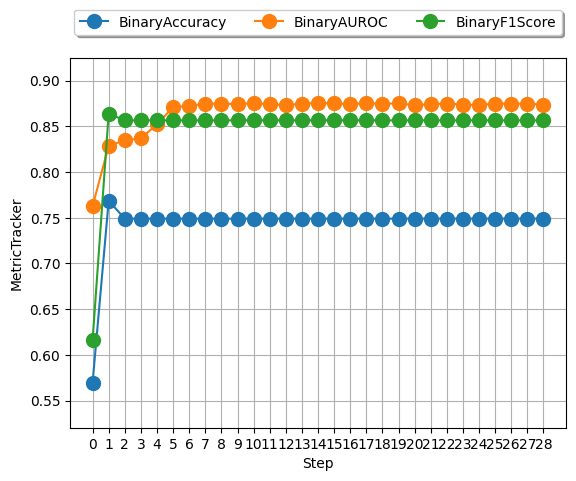

In [32]:
approx_train_tracker.plot()
plt.show()

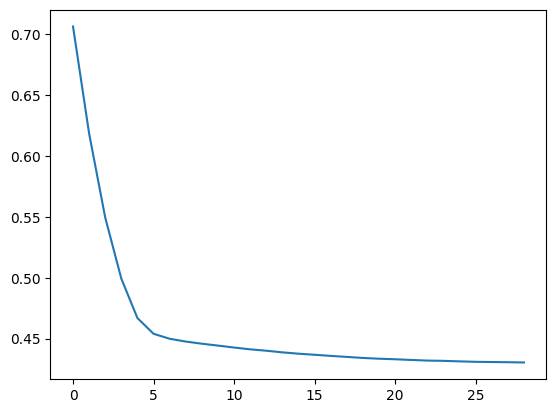

In [33]:
plt.plot(approx_train_losses);
plt.show()

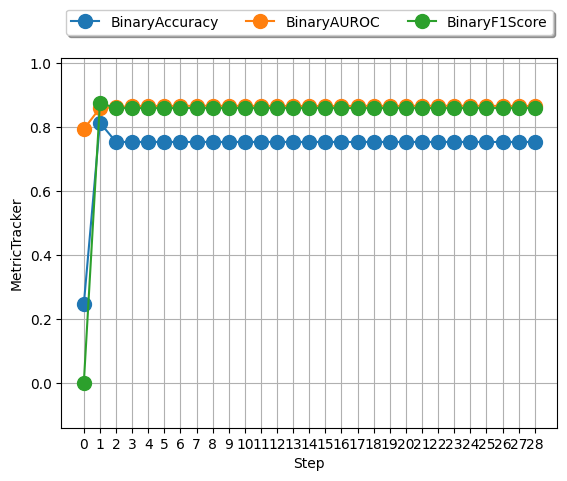

In [34]:
test_tracker.plot();
plt.show()

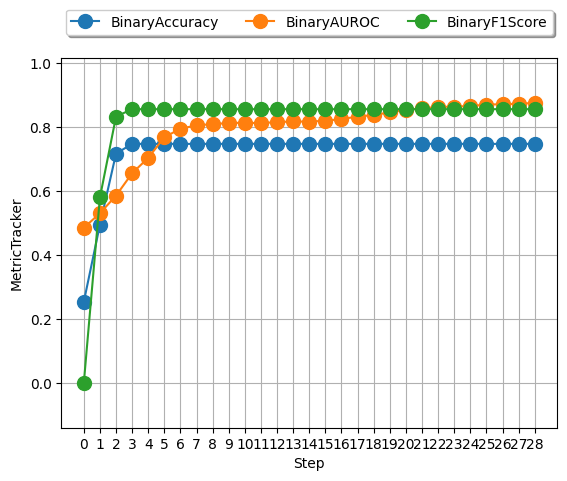

In [23]:
approx_train_tracker.reset_all()
train_tracker.reset_all()
val_tracker.reset_all()
test_tracker.reset_all()